In [1]:
# Description: This program uses an artificial recurrent neural network called 
# Long Short Term Memory (LSTM) to predict the closing stock price of a corporation 
#(Amazon) using the past 60 day stock price.


In [2]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

C:\Users\wilso\Anaconda3\envs\tf\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


In [3]:
#Get the data from web
df = web.DataReader('AMZN', data_source = 'yahoo', start = '2012-01-01', end = '2020-06-18')
#show the data 
df 

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,179.479996,175.550003,175.889999,179.029999,5110800,179.029999
2012-01-04,180.500000,176.070007,179.210007,177.509995,4205200,177.509995
2012-01-05,178.250000,174.050003,175.940002,177.610001,3809100,177.610001
2012-01-06,184.649994,177.500000,178.070007,182.610001,7008400,182.610001
2012-01-09,184.369995,177.000000,182.759995,178.559998,5056900,178.559998
...,...,...,...,...,...,...
2020-06-12,2621.479980,2503.350098,2601.209961,2545.020020,5429600,2545.020020
2020-06-15,2584.000000,2508.000000,2526.600098,2572.679932,3865100,2572.679932
2020-06-16,2620.000000,2576.000000,2620.000000,2615.270020,3585600,2615.270020


In [4]:
#show rows and columns of the dataset
df.shape 

(2129, 6)

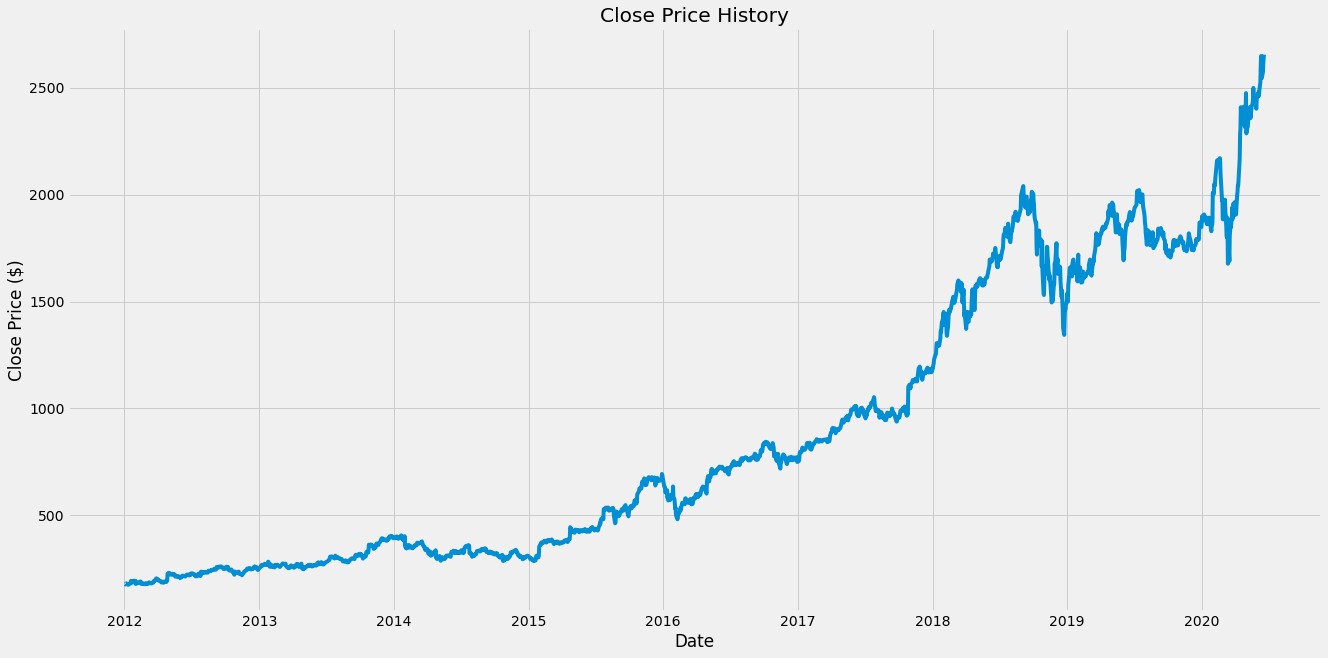

In [5]:
#Visualize the closing price history 
plt.figure(figsize = (20,10))
plt.plot(df['Close'])
plt.title('Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.show()

In [6]:
#Create a new dataframe with only the 'Close' column f
data = df.filter(['Close'])

#Converting the dataframe to a numpy array 
dataset = data.values 

#Get the number of rows to train the model (80%-20% split)
train_data_len = math.ceil(len(dataset) *0.8)

In [7]:
#Scale all data to be values between 0 and 1 before feeding it to Neural Networ 
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset)


In [8]:
#Create the scaled training data set 
train_data = scaled_data[0:train_data_len, :]

#Split the data into x_train and y_train datasets 
x_train = []
y_train = []

for i in range(60,len(train_data)): 
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [9]:
#Convert x_train and y_train to numpy arrays for model training 
x_train, y_train = np.array(x_train), np.array(y_train)

In [10]:
#Reshape the data into the shape accepted by LSTM 
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))


In [11]:
#Build LSTM model 
model = Sequential()
model.add(LSTM(units=50, return_sequences = True, 
              input_shape = (x_train.shape[1],1)))
model.add(LSTM(units = 50, return_sequences = False))
model.add(Dense(units = 25))
model.add(Dense(units =1))

In [12]:
#Compile the model 
model.compile(optimizer='adam', loss = 'mean_squared_error')

In [13]:
#Train the model. batch Batch size is the total number of training examples present 
#in a single batch, and epoch is the number of iterations when an entire data 
#set is passed forward and backward through the neural network.
model.fit(x_train, y_train, batch_size = 1, epochs = 1)

1644/1644 [==============================] - 30s 18ms/step - loss: 7.0985e-04


In [14]:
#Test dataset 
test_data = scaled_data[train_data_len - 60: , : ]

#Create the x_test and y_test datasets
x_test = []
y_test = dataset[train_data_len :, :] 
for i in range (60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [20]:
#Convert x_test to a numpy array
x_test = np.array(x_test)
#Reshape the data into the shape accepted by the LSTM 
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))


In [21]:
#Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) #undo scaling


In [30]:
#Calculate the value of RMSE 
rmse = np.sqrt(np.mean(((predictions - y_test)**2)))
rmse

74.1945484243668

C:\Users\wilso\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


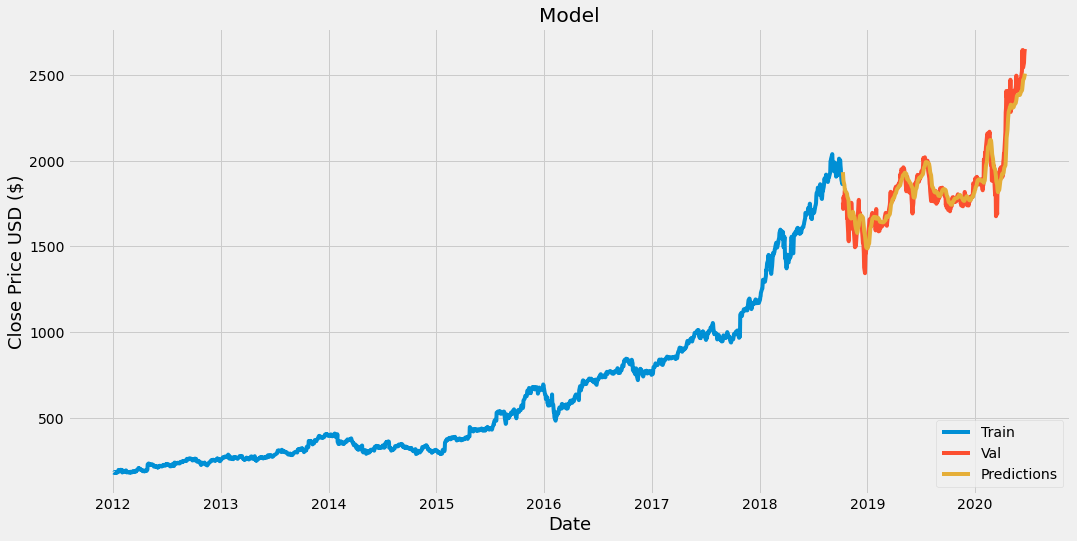

In [32]:
#Plot/Create the data for the graph
train = data[:train_data_len]
valid = data[train_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [33]:
#show the valid and predicted prices
valid

,Close,Predictions
Date,,
2018-10-10,1755.250000,1934.300293
2018-10-11,1719.359985,1910.894653
2018-10-12,1788.609985,1882.058228
2018-10-15,1760.949951,1859.946533
2018-10-16,1819.959961,1840.640869
...,...,...
2020-06-12,2545.020020,2473.037109
2020-06-15,2572.679932,2481.725098
2020-06-16,2615.270020,2488.930908


In [35]:
#Assume I want to get the price of Amazon on 6/16 
amzn_quote = web.DataReader('AMZN', data_source = 'yahoo', start = '2012-01-01', end = '2020-06-14')

#Create new df 
new_df = amzn_quote.filter(['Close'])

#Get the last 60 day closing price
last_60_days = new_df[-60:].values

#Scale data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)

#create empty list
X_test = []

X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[2481.725]]


In [45]:
#Check actual closing price 
amzn_quote2 = web.DataReader('AMZN', data_source = 'yahoo', start = '2020-06-15', end = '2020-06-15')
print(amzn_quote2['Close'])

Date
2020-06-15    2572.679932
Name: Close, dtype: float64
